In [32]:
import sys 
sys.path.append('..')
import networkx as nx
import EoNlocal as EoN
import quarantines as Q 
import utils
import random
import matplotlib.pyplot as plt
import gc
import ipywidgets as widgets
import quarantines_mongo as qm 
from pymongo import MongoClient
import numpy as np 
import matplotlib.pyplot as plt 

In [20]:
client = MongoClient('localhost', 27017)


In [24]:
def collect_qprops_by_name(db, name):
    collection = db['quarantine_by_props']
    docs = collection.find({'name': name}, projection=['quarantine_props', 'iter_num', 'final_R', 'max_I'])
    return list(docs)

In [25]:
docs = collect_qprops_by_name(db, 'smallbar')
docs

[{'_id': ObjectId('5f82068d5bf4cae4927316c1'),
  'quarantine_props': 0.0,
  'iter_num': 0,
  'final_R': 4921,
  'max_I': 3095},
 {'_id': ObjectId('5f82068e5bf4cae4927316c2'),
  'quarantine_props': 0.0,
  'iter_num': 1,
  'final_R': 4924,
  'max_I': 3108},
 {'_id': ObjectId('5f82068e5bf4cae4927316c3'),
  'quarantine_props': 0.0,
  'iter_num': 2,
  'final_R': 4933,
  'max_I': 3064},
 {'_id': ObjectId('5f82068f5bf4cae4927316c4'),
  'quarantine_props': 0.0,
  'iter_num': 3,
  'final_R': 4929,
  'max_I': 3041},
 {'_id': ObjectId('5f82068f5bf4cae4927316c5'),
  'quarantine_props': 0.0,
  'iter_num': 4,
  'final_R': 4935,
  'max_I': 3046},
 {'_id': ObjectId('5f8206905bf4cae4927316c6'),
  'quarantine_props': 0.0,
  'iter_num': 5,
  'final_R': 4931,
  'max_I': 3065},
 {'_id': ObjectId('5f8206905bf4cae4927316c7'),
  'quarantine_props': 0.0,
  'iter_num': 6,
  'final_R': 4928,
  'max_I': 3026},
 {'_id': ObjectId('5f8206915bf4cae4927316c8'),
  'quarantine_props': 0.0,
  'iter_num': 7,
  'final_R': 

In [33]:
def group_by_qprop(db, name):
    """
    Collects from db.quarantine_by_prop all nodes with the given name
    and builds a doc like 
    {qprop: {max_I: [maxI_1, maxI_2, ...],
             final_R}}
    """
    # and builds a doc like 
    collection = db['quarantine_by_props']
    docs = collection.find({'name': name}, projection=['graph_id', 'quarantine_props', 'iter_num', 'final_R', 'max_I'])
    outdoc = {} 
    N = None 
    for doc in docs:
        if N is None:
            N = db.graphs.find_one(doc['graph_id'])['N']
        if doc['quarantine_props'] not in outdoc:
            outdoc[doc['quarantine_props']] = {'max_I': [], 'final_R': []}
        subdoc = outdoc[doc['quarantine_props']]
        subdoc['max_I'].append(doc['max_I'] / N)
        subdoc['final_R'].append(doc['final_R'] / N)
    return outdoc 

    
def gather_by_qprop(groups, i_or_r):
    assert i_or_r in ['I', 'R']
    triples = [] # will have (qprop, mean, stdev) sorted according to qprop 
    def getter(doc):
        if i_or_r == 'I':
            return doc['max_I']
        return doc['final_R']
    
    for qprop, subdoc in groups.items(): 
        sublist = getter(subdoc)
        triples.append((qprop, np.mean(sublist), np.std(sublist)))
    return sorted(triples, key=lambda t: t[0])


        
        

In [38]:
max_i_trips = gather_by_qprop(group_by_qprop(db, 'smallbar'), 'R')

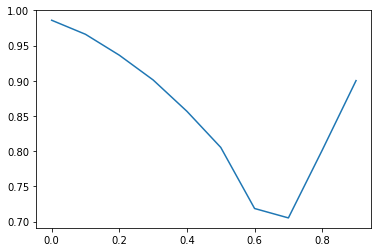

In [39]:
plt.plot(*zip(*[(_[0], _[1]) for _ in max_i_trips]))